# create waller 

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
subbasins = pd.read_excel('Waller_HMS_model_data.xlsx', sheet_name=0)
reservoirs = pd.read_excel('Waller_HMS_model_data.xlsx', sheet_name=1)
nodes = pd.read_excel('Waller_HMS_model_data.xlsx', sheet_name=2)
reaches = pd.read_excel('Waller_HMS_model_data.xlsx', sheet_name=3)

In [3]:
cross_section=pd.read_excel('/Users/future_water_system/Desktop/Data/reach_cross_section_info.xlsx')

In [4]:
shp = gpd.read_file('/Users/future_water_system/Desktop/Data/Waller_Creek_Segments/')

In [5]:
ft_to_m = 0.3048

In [6]:
M = len(reservoirs) + len(nodes)
K = len(reaches)

superjunctions = pd.DataFrame(np.arange(M), columns=['id'])
superlinks = pd.DataFrame(np.arange(K), columns=['id'])

In [7]:
superjunctions['name'] = nodes['Name'].tolist() + reservoirs['Name'].tolist()
superlinks['name'] = reaches['Name'].tolist()


In [8]:
superjunctions.set_index('name', drop=True, inplace=True)
superlinks.set_index('name', drop=True, inplace=True)

In [9]:
shp_subset = shp.dropna(subset=['REACH_NAME'])
reaches_haslen = reaches.dropna(subset=['Length (FT)'])
reaches_shapelen = reaches.dropna(subset=['Shape Length'])

In [10]:
nodes_subset = nodes[nodes['Downstream'].isin(superlinks.index.values)]
reservoirs_subset = reservoirs[reservoirs['Downstream'].isin(superlinks.index.values)]

In [11]:
upstream_nodes = (nodes_subset.set_index('Downstream')
                  .reindex(superlinks.index.values).dropna(subset=['Name'])['Name'])

In [12]:
upstream_reservoirs = (reservoirs_subset.set_index('Downstream')
                       .reindex(superlinks.index.values).dropna(subset=['Name'])['Name'])

In [13]:
reaches.index = reaches['Name']

In [14]:
# Remove Reilly pond
upstream_reservoirs.loc['R_WLR06'] = 'J_WLR06_US_POND_REILLY'
# Remove Central park pond
reaches.loc['R_HEM04', 'Downstream'] = 'J_HEM04_COMB_AT_38TH'
# Remove another node with no downstream reach
reaches.loc['R_HEM03', 'Downstream'] = 'J_HEM04_COMB_AT_38TH'
# Remove another disconnected node
reaches.loc['R_WLR19', 'Downstream'] = 'J_WLR23_12TH'
# Remove
reaches.loc['R_WLR04', 'Downstream'] = 'J_WLR05_COMB_AT_HUNTLAND'
# Remove
reaches.loc['R_HEM07', 'Downstream'] = 'J_WLR18_COMB_HEMP'
# Remove00
reaches.loc['R_WLR10', 'Downstream'] = 'J_WLR12_COMB_AT_DUVAL'
# Remove
reaches.loc['R_WLR15', 'Downstream'] = 'J_WLR18_COMB_HEMP'

In [15]:
outfall = {'id' : len(superjunctions), 'z_inv' : 130., 'h_0' : 1e-5,
           'bc' : True, 'storage' : 'functional', 'a' : 0., 'b' : 0.,
           'c' : 100., 'max_depth' : np.inf}

In [16]:
superjunctions.loc[nodes['Name'].values, 'z_inv'] = ft_to_m * nodes.set_index('Name')['Lowest elevation'].values
superjunctions['h_0'] = 1e-5
superjunctions['bc'] = False
superjunctions['storage'] = 'functional'
superjunctions['a'] = 0.
superjunctions['b'] = 0.
superjunctions['c'] = 100.
superjunctions['max_depth'] = np.inf
superjunctions.loc['OUT_COLORADO_RIVER'] = outfall

In [17]:
superjunctions = (superjunctions.drop('POND_REILLY')
                  .drop('POND_CENTRAL_PARK')
                  .drop('J_HEM02_38TH')
                  .drop('J_WLR22_US_of_12TH')
                  .drop('J_WLR04_TRIB_AT_HUNTLAND')
                  .drop('J_HEM07_DEAN_KEETON')
                  .drop('J_WLR11_MAIN_AT_DUVAL')
                  .drop('J_WLR17_DEAN_KEETON'))
superjunctions['id'] = np.arange(len(superjunctions))

In [18]:
superlinks['sj_0'] = -1
superlinks.loc[upstream_nodes.index.values, 'sj_0'] = superjunctions.loc[upstream_nodes.values, 'id'].values
superlinks.loc[upstream_reservoirs.index.values, 'sj_0'] = superjunctions.loc[upstream_reservoirs.values, 'id'].values
superlinks['sj_1'] = superjunctions.loc[reaches['Downstream'].values, 'id'].values
superlinks['in_offset'] = 0.
superlinks['out_offset'] = 0.
#superlinks.loc[shp_subset['REACH_NAME'].values, 'dx'] = ft_to_m * shp_subset['Shape_Leng'].values
superlinks.loc[reaches_haslen['Name'].values, 'dx'] = ft_to_m * reaches_haslen['Length (FT)'].values
superlinks.loc[reaches_shapelen['Name'].values, 'dx'] = ft_to_m * reaches_shapelen['Shape Length'].values
superlinks['n'] = 0.035
superlinks.loc[reaches_haslen['Name'].values, 'n'] = reaches_haslen["Manning's n"].values
superlinks['shape'] = 'rect_open'
superlinks['g1'] = 10.
superlinks['g2'] = 5.
superlinks['g3'] = 0.
superlinks['g4'] = 0.
superlinks['Q_0'] = 0.
superlinks['h_0'] = 1e-5
superlinks['ctrl'] = False
superlinks['A_s'] = 1.
superlinks['A_c'] = 0.
superlinks['C'] = 0.

In [20]:
R_WLR01 = reaches.set_index('Name').loc['R_WLR01']
z_inv_upstream_waller = (0.3048 * R_WLR01['Length (FT)'] * R_WLR01['Slope (FT/FT)'] 
                         + superjunctions.iloc[superlinks.loc['R_WLR01', 'sj_1']]['z_inv'])

In [21]:
R_HEM02 = reaches.set_index('Name').loc['R_HEM02']
z_inv_triangle_pond = (0.3048 * R_HEM02['Length (FT)'] * R_HEM02['Slope (FT/FT)'] 
                           + superjunctions.iloc[superlinks.loc['R_HEM02', 'sj_1']]['z_inv'])

In [22]:
R_HEM01 = reaches.set_index('Name').loc['R_HEM01']
z_inv_upstream_hemphill = (0.3048 * R_HEM01['Length (FT)'] * R_HEM01['Slope (FT/FT)'] 
                           + z_inv_triangle_pond)

In [23]:
upstream_waller = {'id' : len(superjunctions), 'z_inv' : z_inv_upstream_waller, 'h_0' : 1e-5,
                   'bc' : False, 'storage' : 'functional', 'a' : 0., 'b' : 0.,
                   'c' : 100., 'max_depth' : np.inf}

upstream_hemphill = {'id' : len(superjunctions) + 1, 'z_inv' : z_inv_upstream_hemphill, 'h_0' : 1e-5,
                   'bc' : False, 'storage' : 'functional', 'a' : 0., 'b' : 0.,
                   'c' : 100., 'max_depth' : np.inf}

In [24]:
superjunctions.loc['UPSTREAM_WALLER'] = upstream_waller
superjunctions.loc['UPSTREAM_HEMPHILL'] = upstream_hemphill
superjunctions.loc['POND_TRIANGLE', 'z_inv'] = z_inv_triangle_pond 

In [25]:
superlinks.loc['R_WLR01', 'sj_0'] = superjunctions.loc['UPSTREAM_WALLER', 'id']
superlinks.loc['R_HEM01', 'sj_0'] = superjunctions.loc['UPSTREAM_HEMPHILL', 'id']
superlinks.loc['R_WLR22', 'sj_0'] = superjunctions.loc['J_WLR25_9TH_COMB_SEWER', 'id']
superlinks.loc['R_WLR24', 'sj_0'] = superjunctions.loc['J_WLR28_CESAR_CHAVEZ', 'id']

In [26]:
superjunctions = superjunctions.reset_index()

In [27]:
superlinks = superlinks.reset_index()

In [28]:
superjunctions.loc[superlinks[~superlinks['sj_1'].isin(superlinks['sj_0'])]['sj_1'].values]

,name,id,z_inv,h_0,bc,storage,a,b,c,max_depth
29,OUT_COLORADO_RIVER,29,130.0,0.00001,True,functional,0.0,0.0,100.0,inf


In [29]:
#superjunctions.to_csv('waller_superjunctions.csv')
#superlinks.to_csv('waller_superlinks.csv')

In [30]:
#superjunctions.loc['POND_REILLY', 'z_inv'] = superjunctions.loc['J_WLR06_US_POND_REILLY', 'z_inv']
#superjunctions.loc['POND_CENTRAL_PARK', 'z_inv'] = superjunctions.loc['J_HEM04_COMB_AT_38TH', 'z_inv']

# cross section infomation 

In [31]:
#exclusive= np.setxor1d(cross_section['reach_name'].values, superlinks.index.values)
#exclusive        

In [32]:
superlinks.index=superlinks['name']

In [33]:
superlinks.loc[cross_section['reach_name'].values,'g1']=cross_section.set_index('reach_name')['y'].values *ft_to_m
superlinks.loc[cross_section['reach_name'].values,'g2']=cross_section.set_index('reach_name')['Bw'].values *ft_to_m
superlinks.loc[cross_section['reach_name'].values,'g3']=1/(cross_section.set_index('reach_name')['z'].values*ft_to_m)

In [34]:
superlinks.loc[['R_HEM01','R_HEM02','R_HEM03','R_HEM04','R_HEM05'],['g1','g2','g3']]=superlinks.loc['R_HEM06',['g1','g2','g3']].values
superlinks.loc[['R_WLR01','R_WLR02'],['g1','g2','g3']]=superlinks.loc['R_WLR03',['g1','g2','g3']].values
superlinks.loc[['R_WLR04'],['g1','g2','g3']]=superlinks.loc['R_WLR05',['g1','g2','g3']].values
superlinks.loc[['R_WLR21'],['g1','g2','g3']]=superlinks.loc['R_WLR20',['g1','g2','g3']].values


In [35]:
superlinks.index=superlinks['id']
#superlinks.to_csv('superlinks_cross_section_updated.csv')

# curve_number + unit hydrograph : Q_in 

In [37]:
# calculate pervious CN
import numpy as np
from sklearn.linear_model import LinearRegression

def cal_pervious_CN(CN_C, A_Imp): 
    ###########initial value setting########## 
    CN_C=CN_C
    A_Imp=A_Imp
    pre_x = np.array([A_Imp]).reshape((-1, 1))
    ##########################################

    # Create a numpy array of data:
    x = np.array([0, 100]).reshape((-1, 1)) # Impervious area
    y = np.array([CN_C, 99]) #Pervious CN (CN_P)

    # Create an instance of a linear regression model and fit it to the data with the fit() function:
    model = LinearRegression().fit(x, y) 

    # Predict a Response and print it:
    y_pred = model.predict(pre_x)
    
    return y_pred

In [38]:
#runoff calculation of each subbasins
def cal_excess_precip(Precip, unit_hy, CN, Area): 
    Sub_Area=Area
    P=Precip
    CN=CN
    unit_hy=unit_hy
    S = 1000 / CN - 10
    Ia = 0.2 * S

    # Excess precipitation
    Pes = []
    # Infiltration
    Fas = []
    P_now=0
    num=int(len(P))
    for t in range(0,num):
        Pt = P[t]
        P_now=Pt+P_now

        if P_now <= Ia:
            Pe = 0.
        else:        
            Pe = (P_now - 0.2 * S)**2 / (P_now + 0.8 * S)
            Pe=Pe[0]
            
            #Fa = P_now - Pe - Ia

        Pes.append(Pe)
       # Fas.append(Fa)

    Pes = np.array(Pes)
    #Fas = np.array(Fas)

    #unit hydrograph

    unit_hy2=unit_hy/sum(unit_hy)

    #convolution excess and unit_hydrograph
    cov=np.convolve(np.diff(Pes),unit_hy2)
    
    #convert to outflow 
    Area_MI2=Sub_Area
    Area_ft=Area_MI2*2.788*10**7
    Pes_ft=np.diff(Pes)/12
    cov_ft=cov/12
    outflow =(cov_ft*Area_ft)/120 
    return Pes, outflow





In [102]:
#Rain data 
#output = pd.read_csv('WLR01_output.csv') #scs_storm_10%
#Precip = output['Precip']
#output = pd.read_csv('/Users/future_water_system/Desktop/Data/precipitation_scs_storm_50_-_Sheet1.csv')
#Precip = output['precipitation']

#USGS previous Rain data 
output = pd.read_excel('/Users/future_water_system/Desktop/Data/rainfall data/rainfall_0728-0902_USGS_302814097444799.xlsx') 
#output=output[output['date']=='2022-08-18']
#output1=output[output['date']=='2022-08-30']
output2=output[output['date']=='2022-08-31']
output3=output[output['date']=='2022-09-01']
#output4=output[output['date']=='2022-09-02']
output=pd.concat([output2,output3])
output=output.reset_index(drop=True)

In [104]:

for i in range(0, len(output['time'])):
    d=int(round(output['date'][i].timestamp()))
    h=int(output['time'][i].strftime("%H"))*60*60
    m=int(output['time'][i].strftime("%M"))*60
    s=int(output['time'][i].strftime("%S"))
    datetime=d+h+m+s
    output['time'][i]=pd.to_datetime(datetime * 1e9)
    

Precip=output.set_index('time').resample('10min').mean().interpolate()
Precip = Precip['precipitation']



#unit hydrograph
df = pd.read_csv('unit hydrograph.csv')

lag_time = 26. # minutes
df['time'] = df['time ratios'] * lag_time * 60 * 1e9
df['time'] = pd.to_datetime(df['time'])
hydrograph=df.set_index('time').resample('10min').mean().interpolate()
unit_hy=hydrograph['discharge ratios']



/Users/yeji/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [107]:
# A rainfall event and its Q_in (outflow) of each subbasins

Q_in=pd.DataFrame(columns=superjunctions['name'])
for i in range(0,len(subbasins)):
    CN_C= subbasins['Curve Number'][i]
    A_Imp= subbasins['Impervious Percent'][i]
    Area= subbasins['Area (mi2)'][i]
    Downstream= subbasins['Downstream'][i]
    CN_P=cal_pervious_CN(CN_C, A_Imp)
    CN = CN_P
    
    Pes, outflow=cal_excess_precip(Precip, unit_hy, CN, Area)
    
    #save outflow in Q_in dataframe
   
    if Downstream == 'R_WLR01': 
        Q_in['UPSTREAM_WALLER']=outflow
        print('R_WLR01')
    elif Downstream == 'R_HEM01': 
        Q_in['UPSTREAM_HEMPHILL']=outflow
    else : Q_in[Downstream]=outflow

R_WLR01


In [108]:
exclusive= np.setxor1d(subbasins['Downstream'].values, Q_in.columns)
a = np.array(['R_WLR01','R_HEM01'])
exclusive= np.setxor1d(exclusive,a )
Q_in=Q_in.drop(columns=exclusive)

In [109]:
Q_in=Q_in.fillna(0.)

In [110]:
superlinks['shape'] = 'Trapezoidal' 

In [111]:
#time change min to sec : 2 min(precipitation interval) *60 sec 
Q_in.index=2*60*Q_in.index

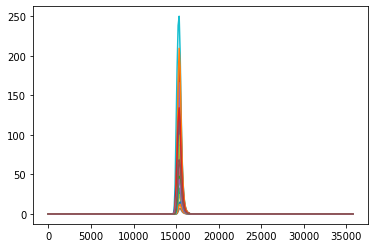

In [112]:
plt.plot(Q_in)

# pipedream simulation 

In [113]:
import pandas as pd
import numpy as np
from pipedream_solver.hydraulics import SuperLink
from pipedream_solver.simulation import Simulation

# Read input data
#input_path = './Pipedream/data/six_pipes'
#input_path2 = './Pipedream/data/validation'
Q_in = Q_in*ft_to_m*ft_to_m*ft_to_m # chage unit (cfs to m^3/s)

In [114]:
# Instantiate superlink model
superlink = SuperLink(superlinks, superjunctions,internal_links=30)
H=[]
# Set constant timestep (in seconds)
dt =2

# Create simulation context manager
with Simulation(superlink, Q_in=Q_in) as simulation:
    # While simulation time has not expired...
    while simulation.t <= simulation.t_end:
        # Step model forward in time
        simulation.step(dt=dt)
        # Record internal depth and flow states
        simulation.record_state()
        # Print progress bar
        simulation.print_progress()
        H.append(superlink.H_j.copy())
H = np.vstack(H)

[==================================================] 100.0% [9.13 s]

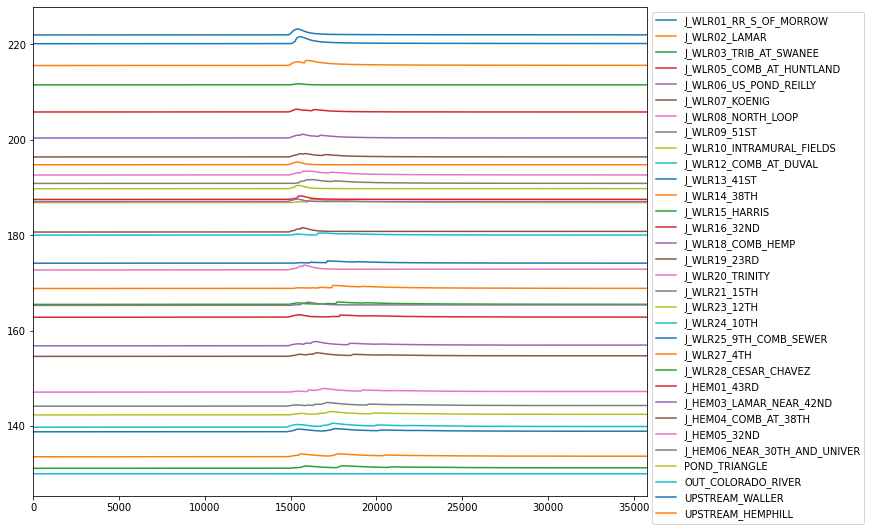

In [115]:
simulation.states.H_j.plot(figsize=(11, 9))
plt.legend(bbox_to_anchor=(1,1), loc="upper left")

In [116]:
H[:,0]


array([220.13361088, 220.13361088, 220.13361088, ..., 220.17101994,
       220.17101753, 220.17101511])

In [117]:
len(superlink.z_inv_j)

32

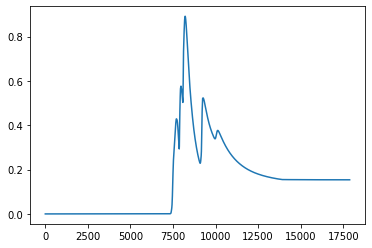

In [118]:
#J_WLR18_COMB_HEMP
a=(H - superlink.z_inv_j)
plt.plot(a[:,14])

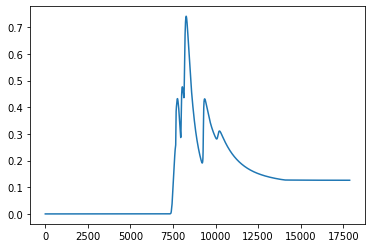

In [119]:
#J_WLR19_23RD
a=(H - superlink.z_inv_j)
plt.plot(a[:,15])

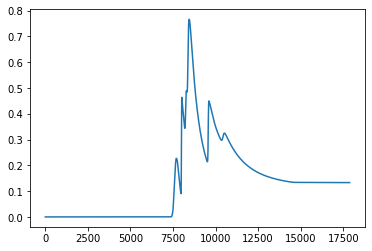

In [120]:
#J_WLR20_TRINITY

a=(H - superlink.z_inv_j)
plt.plot(a[:,16])

In [121]:
a

array([[1.00000000e-05, 9.99999978e-06, 9.99987424e-06, ...,
        1.00000000e-05, 9.99999955e-06, 9.81313769e-06],
       [1.00000000e-05, 9.99999978e-06, 9.99988356e-06, ...,
        1.00000000e-05, 9.99999955e-06, 9.81315051e-06],
       [9.99999997e-06, 9.99999972e-06, 9.96237293e-06, ...,
        1.00000000e-05, 9.99999941e-06, 9.81103744e-06],
       ...,
       [3.74190568e-02, 3.80022803e-02, 4.33995927e-05, ...,
        1.00000000e-05, 2.03775667e-02, 1.04280069e-05],
       [3.74166450e-02, 3.79991710e-02, 4.33966329e-05, ...,
        1.00000000e-05, 2.03763103e-02, 1.04255700e-05],
       [3.74142337e-02, 3.79960624e-02, 4.33936733e-05, ...,
        1.00000000e-05, 2.03750541e-02, 1.04231403e-05]])

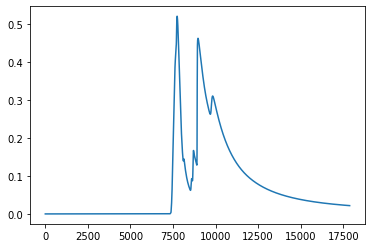

In [122]:
#J_WLR16_32ND
a=(H - superlink.z_inv_j)
plt.plot(a[:,13])

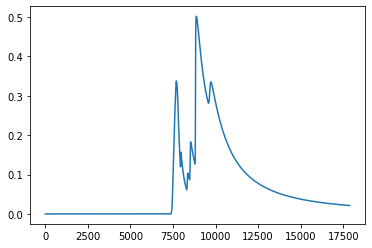

In [123]:
#J_WLR15_HARRIS
a=(H - superlink.z_inv_j)
plt.plot(a[:,12])

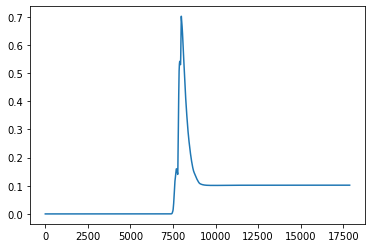

In [124]:
#J_HEM06_NER_30HTH_AND_UNIVER
a=(H - superlink.z_inv_j)
plt.plot(a[:,27])

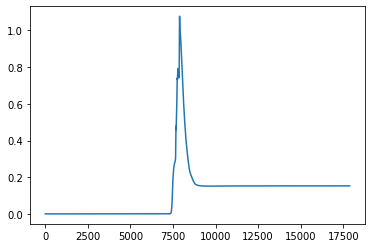

In [125]:

a=(H - superlink.z_inv_j)
plt.plot(a[:,26])

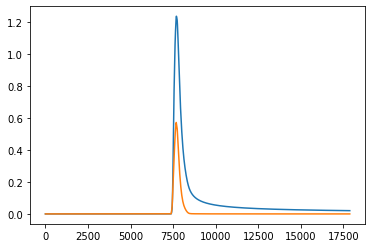

In [126]:
#J_WLR18_COMB_HEMP
a=(H - superlink.z_inv_j)
for i in range(30,32):
    plt.plot(a[:,i])

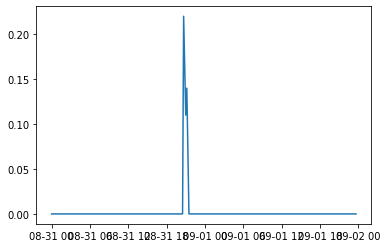

In [127]:
plt.plot(Precip)